In [1]:
#Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta, date
import time
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
%load_ext autoreload
%autoreload 2

from helpers.db_query import *

# Flipped grades

In [4]:
%time grades_df = getFlippedGrades()

CPU times: user 58.8 ms, sys: 9.22 ms, total: 68.1 ms
Wall time: 481 ms


In [5]:
print(grades_df.shape)
grades_df.head()

(419, 6)


,AcademicYear,Grade,PlanSection,PlanCursus,AccountUserID,Repentant
0,2018-2019,5.00,Informatique,IN - Bachelor 2018,46938,0
1,2017-2018,4.25,Génie mécanique,GM - Bachelor 2017,8402,0
2,2017-2018,3.25,Génie électrique et électronique,EL - Bachelor 2017,9866,0
3,2018-2019,5.50,Informatique,IN - Bachelor 2018,49638,0
4,2017-2018,3.75,Génie mécanique,GM - Bachelor 2017,11354,0


In [6]:
grades_df.groupby("AcademicYear").size()

AcademicYear
2017-2018     92
2018-2019    162
2019-2020    165
dtype: int64

In [7]:
grades_df.Grade.describe()

count    419.000000
mean       3.983294
std        1.192463
min        1.000000
25%        3.250000
50%        4.250000
75%        5.000000
max        6.000000
Name: Grade, dtype: float64

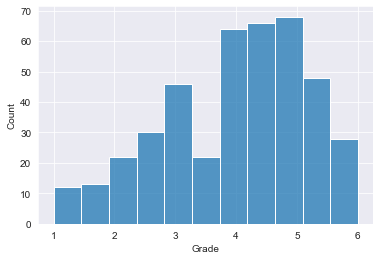

In [8]:
sns.histplot(grades_df.Grade);

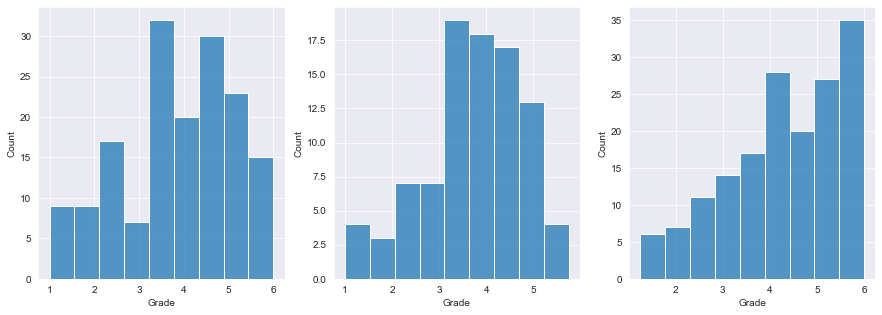

In [9]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for i, year in enumerate(grades_df.AcademicYear.unique()):
    sns.histplot(grades_df.loc[grades_df.AcademicYear == year].Grade, ax=axes[i])

# Control grades

In [10]:
%time control_grades_df = getControlGrades()

CPU times: user 52.7 ms, sys: 5.87 ms, total: 58.6 ms
Wall time: 396 ms


In [11]:
print(control_grades_df.shape)
control_grades_df.head()

(981, 5)


,AcademicYear,Grade,PlanSection,PlanCursus,Repentant
0,2018-2019,4.25,Génie mécanique,GM - Bachelor 2018,1
1,2017-2018,3.25,Génie mécanique,GM - Bachelor 2017,0
2,2018-2019,5.75,Informatique,IN - Bachelor 2018,1
3,2017-2018,3.50,Informatique,IN - Bachelor 2017,0
4,2018-2019,4.50,Sciences et technologies du vivant,SV - Bachelor 2018,1


In [12]:
control_grades_df.groupby("AcademicYear").size()

AcademicYear
2015-2016      1
2016-2017     63
2017-2018    364
2018-2019    262
2019-2020    291
dtype: int64

In [13]:
control_grades_df.Grade.describe()

count    981.000000
mean       3.873089
std        1.161873
min        1.000000
25%        3.000000
50%        4.000000
75%        4.750000
max        6.000000
Name: Grade, dtype: float64

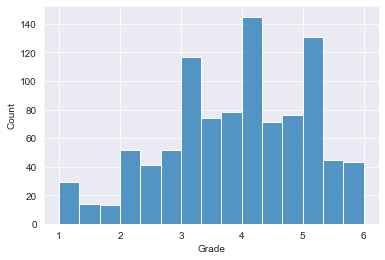

In [14]:
sns.histplot(control_grades_df.Grade);

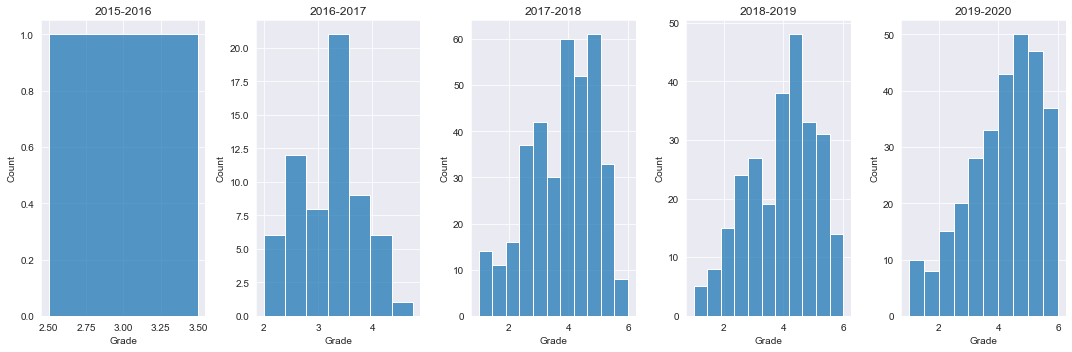

In [15]:
fig, axes = plt.subplots(1,control_grades_df.AcademicYear.nunique(),figsize=(15,5))
for i, year in enumerate(sorted(control_grades_df.AcademicYear.unique())):
    sns.histplot(control_grades_df.loc[control_grades_df.AcademicYear == year].Grade, ax=axes[i])
    axes[i].set_title(year)
fig.tight_layout()

# Integrate only students registered on isa

## Videos

In [33]:
%time videos_df = getVideoEvents(isa_only=False)

CPU times: user 21.5 s, sys: 1.9 s, total: 23.4 s
Wall time: 25.5 s


In [34]:
%time isa_videos_df = getVideoEvents()

CPU times: user 24.5 s, sys: 1.54 s, total: 26 s
Wall time: 27.9 s


In [35]:
event_diff = len(videos_df) - len(isa_videos_df)
user_diff = videos_df.AccountUserID.nunique() - isa_videos_df.AccountUserID.nunique()
print("Filtering removed {} events and {} users".format(event_diff, user_diff))

Filtering removed 37758 events and 89 users


In [36]:
isa_videos_df.drop_duplicates("AccountUserID").groupby("Year").size()

Year
2017     91
2018    161
2019    159
dtype: int64

## Problems

In [37]:
%time problems_df = getProblemEvents(isa_only=False)

CPU times: user 12.3 s, sys: 894 ms, total: 13.2 s
Wall time: 15.9 s


In [38]:
%time isa_problems_df = getProblemEvents()

CPU times: user 11.9 s, sys: 812 ms, total: 12.7 s
Wall time: 15.1 s


In [39]:
event_diff = len(problems_df) - len(isa_problems_df)
user_diff = problems_df.AccountUserID.nunique() - isa_problems_df.AccountUserID.nunique()
print("Filtering removed {} events and {} users".format(event_diff, user_diff))

Filtering removed 13917 events and 50 users


# Missing data inspection

In [43]:
def _getGrades(flipped = True):
    columns = ['StudentSCIPER', 'AcademicYear', 'Grade', 'PlanSection', 'PlanCursus']
    query = """ SELECT distinct {} FROM project_himanshu.Bachelor_Master_Results
            """.format(", ".join(columns))
    if flipped:
        query += "WHERE TeacherSCIPER = 121157 AND SubjectName = 'Algèbre linéaire (classe inversée)'"
    else:
        query += "WHERE SubjectName = 'Algèbre linéaire'"
    sciper_df = queryDB(query, columns)
    print("Raw grades", len(sciper_df))
   
    
    print("\tNb of null grades", pd.isna(sciper_df.Grade).sum())
    sciper_df = sciper_df[~pd.isna(sciper_df).any(axis=1)] # Drop NaN
    
    print("\tNb of STATUT_NOTE_NA", (sciper_df.Grade == "STATUT_NOTE_NA").sum())
    sciper_df = sciper_df[sciper_df.Grade != "STATUT_NOTE_NA"] # Drop grade NA
    
    print("\tNb of STATUT_NOTE_M", (sciper_df.Grade == "STATUT_NOTE_M").sum())
    sciper_df = sciper_df[sciper_df.Grade != "STATUT_NOTE_M"] # Drop grade M
    
    print("\tNb of repeater", sciper_df.duplicated(["StudentSCIPER"]).sum(axis=0))
    sciper_df.Grade = pd.to_numeric(sciper_df.Grade) # Convert grades to Float
    
    return sciper_df

def _getMapping():
    columns = ['AccountUserID', 'SCIPER']
    query = """ SELECT {} FROM project_himanshu.MOOC_ISA_Person_Mapping""".format(", ".join(columns))
    mapping = queryDB(query, columns)
    return mapping

def _getStudentCondition(flipped=True):
    CONDITION_MAPPING_PATH = '../data/lin_alg_moodle/Volunteer-Flipped-Proj.csv'
    conditions_df = pd.read_csv(CONDITION_MAPPING_PATH, index_col=0)
    # Return either the flipped or the control group
    conditions_df = conditions_df.loc[conditions_df.Condition == ("Flipped" if flipped else "Control")]
    # Remove useless columns and remove duplicates (since a student can take the course during different years)
    conditions_df = conditions_df.drop(columns=["Course.Year", "Condition"]).drop_duplicates()
    return conditions_df

def _labelRepeaters(df):
    df["Repeater"] = 0
    #Sort by academic year so that only second year is labeled repeater
    df.loc[df.sort_values(by="AcademicYear").duplicated("StudentSCIPER"),"Repeater"] = 1
    return df

In [46]:
def _getFlippedGrades():
    conditions_df = _getStudentCondition() # 504
    print("Nb students in flipped group",len(conditions_df))
    
    sciper_df = _getGrades() # 420
    print("Filtered grades (with repeater)",len(sciper_df))
    
    sciper_df = sciper_df.merge(conditions_df, left_on='StudentSCIPER', right_on="SCIPER") #420
    mapping = _getMapping() #1123
    userID_df = sciper_df.merge(mapping) #419
    print("Student not included in mapping:", len(sciper_df.SCIPER[~sciper_df.SCIPER.isin(mapping.SCIPER)].dropna(how = 'all')))
    print("Final number of flipped grades", len(userID_df))
    
    userID_df = _labelRepeaters(userID_df)
    userID_df.drop(columns=['StudentSCIPER', 'SCIPER'], inplace=True)  
    return userID_df

In [47]:
_getFlippedGrades();

Nb students in flipped group 504
Raw grades 446
	Nb of null grades 9
	Nb of STATUT_NOTE_NA 15
	Nb of STATUT_NOTE_M 2
	Nb of repeater 7
Filtered grades (with repeater) 420
Student not included in mapping: 1
Final number of flipped grades 419


In [48]:
def _getControlGrades():
    conditions_df = _getStudentCondition(flipped=False) # Get the Control group list of SCIPER
    print("Nb students in control group",len(conditions_df))
    sciper_df = _getGrades(flipped=False) # Get the grades by SCIPER
    print("Filtered grades (keeping repeaters)", len(sciper_df))
    # Keep only Control students
    print("Student not included in the control group:", len(sciper_df.StudentSCIPER[~sciper_df.StudentSCIPER.isin(conditions_df.SCIPER)].dropna(how = 'all')))
    sciper_df = sciper_df.merge(conditions_df, left_on='StudentSCIPER', right_on="SCIPER")
    sciper_df = labelRepeaters(sciper_df)
    sciper_df.drop(columns=['StudentSCIPER', 'SCIPER'], inplace=True)
    print("Final number of control grades", len(sciper_df))
    return sciper_df

In [49]:
grades = _getControlGrades();

Nb students in control group 896
Raw grades 1195
	Nb of null grades 12
	Nb of STATUT_NOTE_NA 15
	Nb of STATUT_NOTE_M 9
	Nb of repeater 221
Filtered grades (keeping repeaters) 1159
Student not included in the control group: 178
Final number of control grades 981


# Repeater grades mapping between ISA and Courseware

In [50]:
user_info = getUserInfo()
cw_repeaters = user_info[user_info.duplicated("AccountUserID")].AccountUserID.values
cw_repeaters = user_info.loc[user_info.AccountUserID.isin(cw_repeaters)].sort_values(by=["AccountUserID","Year"])
cw_repeaters

,AccountUserID,Timestamp,Year,Week,Weekday
32,10391,1505077076,2017,36,07
33,10391,1536245224,2018,36,04
144,45162,1536245228,2018,36,04
145,45162,1567423917,2019,36,01
221,45327,1536245222,2018,36,04
222,45327,1567423935,2019,36,01
131,45459,1536245225,2018,36,04
132,45459,1567423915,2019,36,01
103,45954,1536245224,2018,36,04
104,45954,1567423936,2019,36,01


In [51]:
grades = getFlippedGrades()
isa_repeaters = grades[grades.duplicated("AccountUserID")].AccountUserID.values
isa_repeaters = grades.loc[grades.AccountUserID.isin(isa_repeaters)].sort_values(by=["AccountUserID","AcademicYear"])
isa_repeaters

,AcademicYear,Grade,PlanSection,PlanCursus,AccountUserID,Repeater
111,2017-2018,3.25,Sciences et technologies du vivant,SV - Bachelor 2017,10391,0
112,2018-2019,4.50,Sciences et technologies du vivant,SV - Bachelor 2018,10391,1
176,2018-2019,3.00,Informatique,IN - Bachelor 2018,45162,0
177,2019-2020,4.00,Informatique,IN - Bachelor 2019,45162,1
194,2018-2019,2.50,Sciences et technologies du vivant,SV - Bachelor 2018,45327,0
195,2019-2020,5.00,Ingénierie des sciences du vivant,SV - Bachelor 2019,45327,1
243,2018-2019,3.00,Microtechnique,MT - Bachelor 2018,45459,0
244,2019-2020,4.75,Microtechnique,MT - Bachelor 2019,45459,1
263,2018-2019,2.25,Microtechnique,MT - Bachelor 2018,45954,0
264,2019-2020,4.00,Microtechnique,MT - Bachelor 2019,45954,1
